Trying out LangGraph

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain-community langsmith langchain-experimental sentence_transformers tavily-python pandas fsspec huggingface_hub langchain-mistralai nltk langchain-ollama
%pip install 'urllib3<2'

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "test_langgraph"
os.environ["MISTRAL_API_KEY"] = ""
os.environ["TAVILY_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""

In [3]:
import re

import numpy as np
from langchain_core.tools import tool
import pandas as pd

df = pd.read_json("hf://datasets/yixuantt/MultiHopRAG/MultiHopRAG.json")
corpus = pd.read_json("hf://datasets/yixuantt/MultiHopRAG/corpus.json")

/Users/terra/Desktop/demo/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df.head()
print(df['query'][2])

Who is the figure associated with generative AI technology whose departure from OpenAI was considered shocking according to Fortune, and is also the subject of a prevailing theory suggesting a lack of full truthfulness with the board as reported by TechCrunch?


In [5]:
corpus.head()

,title,author,source,published_at,category,url,body
0,200+ of the best deals from Amazon's Cyber Mon...,None,Mashable,2023-11-27 08:45:59+00:00,entertainment,https://mashable.com/article/cyber-monday-deal...,"Table of Contents Table of Contents Echo, Fire..."
1,ASX set to drop as Wall Street’s September slu...,Stan Choe,The Sydney Morning Herald,2023-09-26 19:11:30+00:00,business,https://www.smh.com.au/business/markets/asx-se...,"ETF provider Betashares, which manages $30 bil..."
2,Amazon sellers sound off on the FTC's 'long-ov...,None,Cnbc | World Business News Leader,2023-10-06 21:31:00+00:00,business,https://www.cnbc.com/2023/10/06/amazon-sellers...,A worker sorts out parcels in the outbound doc...
3,"Christmas Day preview: 49ers, Ravens square of...","Colum Dell, Yardbarker",Yardbarker,2023-12-24 23:34:39+00:00,sports,https://www.yardbarker.com/nfl/articles/christ...,"Christmas Day isn't just for the NBA, as the N..."
4,"Raiders vs. Lions live score, updates, highlig...",Dan Treacy,Sporting News,2023-10-30 22:20:03+00:00,sports,https://www.sportingnews.com/us/nfl/news/raide...,The Lions just needed to get themselves back i...


In [ ]:
import numpy as np
import nltk 
nltk.download('punkt_tab')
from langchain.document_loaders import DataFrameLoader
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from nltk.tokenize import sent_tokenize

model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)

loader = DataFrameLoader(corpus, page_content_column="body")
documents = loader.load()

# Helper function to split document body into sentences
def split_into_sentences(doc):
    return sent_tokenize(doc.page_content)

# VectorStoreRetriever class to store and query sentences
class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: list, sentences: list):
        self._arr = np.array(vectors)  # Embedding vectors for sentences
        self._docs = docs  # Original documents
        self._sentences = sentences  # List of sentence-level content

    @classmethod
    def from_docs(cls, docs):
        all_sentences = []
        
        # Process each document: split it into sentences, generate embeddings
        for doc in docs:
            sentences = split_into_sentences(doc)  # Split into sentences
            all_sentences.extend(sentences)
        
        # Generate embeddings for the sentences
        sentence_embeddings = hf.embed_documents(all_sentences)
        return cls(docs, sentence_embeddings, all_sentences)

    def query(self, query: str, k: int = 5) -> list[dict]:
        # Embed the query
        embed = hf.embed_query(query)
        
        # Calculate similarity scores
        scores = np.array(embed) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        
        # Return the top K similar sentences
        return [
            {"sentence": self._sentences[idx], "similarity": scores[idx]}
            for idx in top_k_idx_sorted
        ]

# Initialize the retriever with sentence-level embeddings
#retriever = VectorStoreRetriever.from_docs(documents)

retriever = None 

def initialize_retriever():
    model_name = "BAAI/bge-small-en"
    model_kwargs = {"device": "cpu"}
    encode_kwargs = {"normalize_embeddings": True}
    hf = HuggingFaceBgeEmbeddings(
        model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
    )
    # Load corpus
    corpus = pd.read_json("hf://datasets/yixuantt/MultiHopRAG/corpus.json")
    loader = DataFrameLoader(corpus, page_content_column="body")
    docs = loader.load()

    # Process documents into sentences
    all_sentences = []
    for doc in docs:
        sentences = split_into_sentences(doc)
        all_sentences.extend(sentences)

    # Generate embeddings
    sentence_embeddings = hf.embed_documents(all_sentences)

    # Create the retriever
    retriever = VectorStoreRetriever(docs, sentence_embeddings, all_sentences)

    return retriever


[nltk_data] Downloading package punkt_tab to /Users/terra/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [18]:
retriever = initialize_retriever()

In [ ]:
@tool
def find_answer_in_docs(query: str) -> str:
    """do RAG"""
    # Perform query and get the most relevant sentences
    docs = retriever.query(query, k=4)
    
    # Return the retrieved sentences as a string
    retrieval_results = "\n\n".join([doc["sentence"] for doc in docs])
    return retrieval_results

In [8]:
from tavily import TavilyClient

@tool 
def search_web(query: str) -> str:
    """search the web"""
    tavily_client = TavilyClient(api_key="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")
    response = tavily_client.search(query)
    return response

utils

In [9]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
         #   print("TYPE: ", message.type) #human, ai, tool
         #   print("CONTENT: ", message.content)
            msg_repr = message.pretty_repr(html=True)

            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)
            

def add_to_results(event: dict, results: dict):
    message = event.get("messages")
    if message:
         if isinstance(message, list):
            message = message[-1]
         if message.content != "":
            results[message.type] = message.content

state 
Define our StateGraph's state as a typed dictionary containing an append-only list of messages. These messages form the chat history, which is all the state our simple assistant needs.

In [10]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Agent¶

Next, define the assistant function. This function takes the graph state, formats it into a prompt, and then calls an LLM for it to predict the best response.

In [11]:
from langchain_core.runnables import Runnable, RunnableConfig
from datetime import date, datetime
from langchain_mistralai import ChatMistralAI
from langchain_ollama import ChatOllama
from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_core.prompts import ChatPromptTemplate

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
        #    passenger_id = configuration.get("passenger_id", None)
            state = {**state}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

part_1_tools = [find_answer_in_docs, search_web]

my_rate_limiter = InMemoryRateLimiter(
    requests_per_second = .05,
    check_every_n_seconds = 0.5,
    max_bucket_size = 5
)


llm = ChatOllama(
    model="mistral",
    temperature=0,
    max_retries=3,
    rate_limiter=my_rate_limiter,
    timeout = 240
    # other params...
).bind_tools(part_1_tools)


llm2 = ChatMistralAI(
    model="mistral-large-latest",
    temperature=0,
    max_retries=3,
    rate_limiter=my_rate_limiter,
    timeout = 240
    # other params...
).bind_tools(part_1_tools)

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a question answering assistant. "
            "Invoke the tools given to you when needed to respond to user queries."
            "Use the documents given to you for any questions on English magazines such as 'The Age', 'Fortune', 'The Verge' and 'TechCrunch'"
            " Provide a really short answer."
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "All queries have an answer."
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)


part_1_assistant_runnable = primary_assistant_prompt | llm2 #.bind_tools(part_1_tools)

def build_part_1_assistant_runnable():

    part_1_tools = [find_answer_in_docs, search_web]

    my_rate_limiter = InMemoryRateLimiter(
        requests_per_second = .05,
        check_every_n_seconds = 0.5,
        max_bucket_size = 5
    )
    
    llm2 = ChatMistralAI(
    model="mistral-large-latest",
    temperature=0,
    max_retries=3,
    rate_limiter=my_rate_limiter,
    timeout = 240
    # other params...
    ).bind_tools(part_1_tools)

    primary_assistant_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a question answering assistant. "
                "Invoke the tools given to you when needed to respond to user queries."
                "Use the documents given to you for any questions on English magazines such as 'The Age', 'Fortune', 'The Verge' and 'TechCrunch'"
                " Provide a really short answer."
                " When searching, be persistent. Expand your query bounds if the first search returns no results. "
                " If a search comes up empty, expand your search before giving up."
                "All queries have an answer."
                "\nCurrent time: {time}.",
            ),
            ("placeholder", "{messages}"),
        ]
    ).partial(time=datetime.now)

    return primary_assistant_prompt | llm2

/var/folders/g7/xc8nt9ms647dgxyl0kpl62b00000gq/T/ipykernel_11502/3933804469.py:33: LangChainBetaWarning: Introduced in 0.2.24. API subject to change.
  my_rate_limiter = InMemoryRateLimiter(


Define Graph¶

Now, create the graph. The graph is the final assistant for this section.

In [12]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
part_1_graph = builder.compile(checkpointer=memory)

def get_part_1_graph():
    return part_1_graph

def initialize_part_1_graph():

    builder = StateGraph(State)
    part_1_tools =  [find_answer_in_docs, search_web]
    memory = MemorySaver()

    builder.add_node("assistant", Assistant(build_part_1_assistant_runnable()))
    builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
    builder.add_edge(START, "assistant")
    builder.add_conditional_edges(
        "assistant",
        tools_condition,
    )
    builder.add_edge("tools", "assistant")

    memory = MemorySaver()
    part_1_graph = builder.compile(checkpointer=memory)
    return part_1_graph

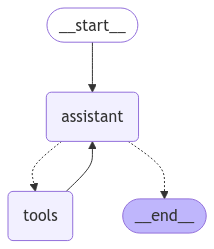

In [13]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Example conversation

get questionds from MultiHopRAG df

In [ ]:
import shutil
import uuid

# Let's create an example conversation a user might have with the assistant
#tutorial_questions = df["query"][:5] 
tutorial_questions = ["hello, can you help wish some questions?","find an open restaurant in edinburgh", df["query"][0]]

# Update with the backup file so we can restart from the original place in each section
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id
    }
}


results = []
_printed = set()
#for question in tutorial_questions:
while True:
    question = input("Your message: ")
    if question.lower() in ["exit", "quit"]:
        break
    result = {}
    events = part_1_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
        add_to_results(event, result)
    results.append(result)



================================ Human Message =================================

hi
================================== Ai Message ==================================

Hi! How can I assist you today?


Evaluation

In [15]:
import pprint as pp
pp.pprint(results)
print()

[{'ai': 'Hi! How can I assist you today?', 'human': 'hi'}]



Evaluation

In [16]:
from langsmith import Client, evaluate
from langchain.evaluation import EvaluatorType
from langchain.smith import RunEvalConfig
from langsmith.schemas import Example, Run
from langsmith.evaluation import EvaluationResult


client = Client()

# Define dataset: these are your test cases
dataset_name = "My Sample Dataset 3"
dataset = client.create_dataset(dataset_name, description="A sample dataset in LangSmith.")
client.create_examples(
  inputs=[
      {"query": "Who is the figure associated with generative AI technology whose departure from OpenAI was considered shocking according to Fortune, and is also the subject of a prevailing theory suggesting a lack of full truthfulness with the board as reported by TechCrunch?"},
      {"query": "recommend a cinema in edinburgh open today"},
      {"query": "thank you for helping me!"}
  ],
  outputs=[
      {"output": "Sam Altman"},
      {"output": "Vue"},
      {"output": "You're welcome"}
  ],
  dataset_id=dataset.id,
)

LangSmithConflictError: Conflict for /datasets. HTTPError('409 Client Error: Conflict for url: https://api.smith.langchain.com/datasets', '{"detail":"Dataset with this name already exists."}')

In [ ]:

def predict_agent_messages(example: dict):
   """Invoke assistant for single tool call evaluation"""
   msg = [ ("user", example["query"]) ]
   messages = part_1_graph.invoke(msg, config)
   return {"response": messages['messages'][-1].content}

# Define your evaluator
def contains_answer(run, example):
   print(example.outputs["output"])
   print(run.outputs)
   if example.outputs["output"] in run.outputs["output"]:
      score = 1
   else:
      score = 0
   return EvaluationResult(
        key="contains answer",
        score=score,
    )


experiment_results = evaluate(
  predict_agent_messages, # Your AI system goes here
  data=dataset_name, # The data to predict and grade over
  evaluators=[contains_answer], # The evaluators to score the results
  experiment_prefix="sample-experiment", # The name of the experiment
  metadata={
    "version": "1.0.1",
    "revision_id": "beta"
  },
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


View the evaluation results for experiment: 'sample-experiment-e5135955' at:
https://smith.langchain.com/o/748f64cf-3528-45fb-82ff-ef191d9b20b3/datasets/8f04f5f5-061b-4b2f-a999-e5d69f705f07/compare?selectedSessions=885753ea-5c14-451a-b145-99477f151a51




0it [00:00, ?it/s]Error running target function: Expected dict, got [('user', 'recommend a cinema in edinburgh open today')]
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_GRAPH_NODE_RETURN_VALUE
Traceback (most recent call last):
  File "/Users/terra/Desktop/demo/.venv/lib/python3.11/site-packages/langsmith/evaluation/_runner.py", line 1675, in _forward
    fn(example.inputs, langsmith_extra=langsmith_extra)
  File "/Users/terra/Desktop/demo/.venv/lib/python3.11/site-packages/langsmith/run_helpers.py", line 617, in wrapper
    raise e
  File "/Users/terra/Desktop/demo/.venv/lib/python3.11/site-packages/langsmith/run_helpers.py", line 614, in wrapper
    function_result = run_container["context"].run(func, *args, **kwargs)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/g7/xc8nt9ms647dgxyl0kpl62b00000gq/T/ipykernel_9620/944510006.py", line 4, in predict_agent_messages
    messages = part_1_grap

Vue
{'output': None}
You're welcome
{'output': None}
Sam Altman
{'output': None}


3it [00:00,  5.46it/s]


In [ ]:

globals()["part_1_graph"] = part_1_graph

In [24]:
%pip install streamlit


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [25]:

import streamlit as st
import uuid


# Initialize session state for the conversation
if "messages" not in st.session_state:
    st.session_state["messages"] = []
if "results" not in st.session_state:
    st.session_state["results"] = []

# Generate unique thread ID for each session
if "thread_id" not in st.session_state:
    st.session_state["thread_id"] = str(uuid.uuid4())


# Configuration for LangGraph
config = {
    "configurable": {
        "thread_id": st.session_state["thread_id"]
    }
}

st.title("LangGraph Chatbot Demo")
st.info("Type your message below and interact with the LangGraph agent. Type 'exit' or 'quit' to end the session.")

# Chat interface
user_input = st.text_input("Your message:", key="user_input")

if user_input:
    # Exit condition
    if user_input.lower() in ["exit", "quit"]:
        st.write("Session ended. Refresh the page to start again.")
        st.stop()

    # Process user input
    st.session_state["messages"].append(("User", user_input))
    result = {}
    graph = initialize_part_1_graph()
    events = graph.stream(
        {"messages": ("user", user_input)}, config, stream_mode="values"
    )

    # Handle streaming events
    _printed = set()
    assistant_response = ""
    tool_output = ""
    for event in events:
        _print_event(event, _printed)
        add_to_results(event, result)

        current_state = event.get("dialog_state")
        
        message = event.get("messages")
        if message:
            if isinstance(message, list):
                message = message[-1]
            if message.type == 'tool':
                tool_output += message.content
            if message.type == 'ai':
                assistant_response += message.content

    # Fallback if no response
    if not assistant_response:
        assistant_response = "I couldn’t process your request. Please try again."

    # Save and display assistant's response
    st.session_state["results"].append(result)
    st.session_state["messages"].append(("Tool output", tool_output))
    st.session_state["messages"].append(("Assistant", assistant_response))

# Display the conversation
for sender, message in st.session_state["messages"]:
    st.markdown(f"**{sender}:** {message}")

2024-12-02 22:44:49.124 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-02 22:44:49.126 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-02 22:44:49.127 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-02 22:44:49.127 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-02 22:44:49.128 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-02 22:44:49.129 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-02 22:44:49.130 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-02 22:44:49.130 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar